In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
user_table = pd.read_csv('./data/Pricing_Test/user_table.csv')
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [4]:
user_table.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [5]:
test_results = pd.read_csv('./data/Pricing_Test/test_results.csv', parse_dates=['timestamp'])
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [7]:
test_results.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

# Data Processing and Cleaning

In [8]:
# check uniquess
print('user_table:\t', user_table['user_id'].unique().shape)
print('test_results:\t', test_results['user_id'].unique().shape)

user_table:	 (275616,)
test_results:	 (316800,)


In [9]:
# merge test_results with user_table
data = pd.merge(left=test_results, right=user_table, how='left', on='user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [10]:
# Problem with the data: test and price not match
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

It seems that there are some problems with the data
* there are a small amount of users who are labelled with `test=0` but actually see price $\$59$
* there are a small amount of users who are labelled with `test=1` but actually see price $\$39$. 

Fortunately, they are only a very small portion of the whole dataset. The first step is to remove these problematic inputs.

In [11]:
# only keep the valid data
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [20]:
# create new column called `revenue`
data['revenue'] = data['converted'] * data['price']

In [21]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


# Visualization

Now, let's check whether or not the test are totally randomized through simple visualization.

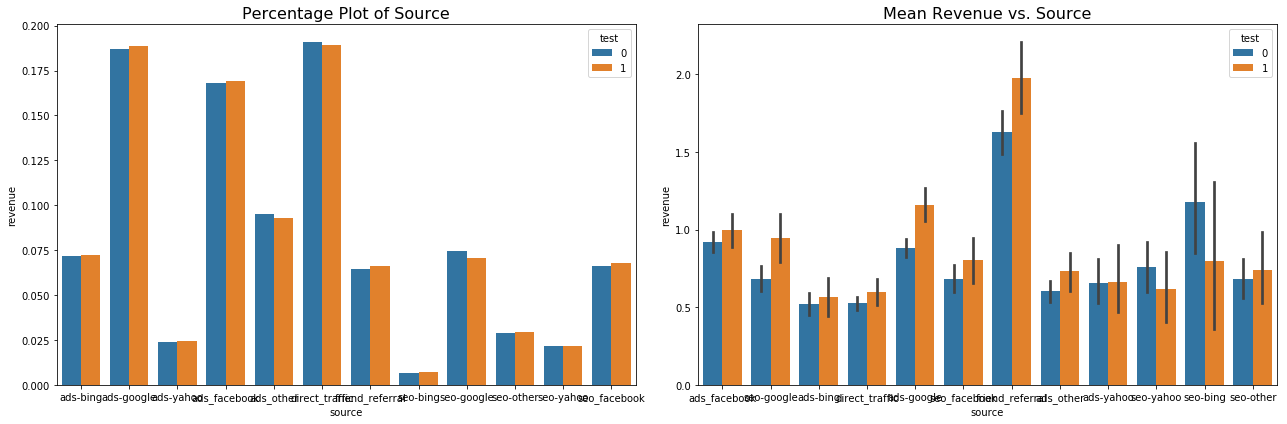

In [22]:
# Visualization of source
count = data[['source', 'test', 'revenue']].groupby(['source', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()
plt.show()

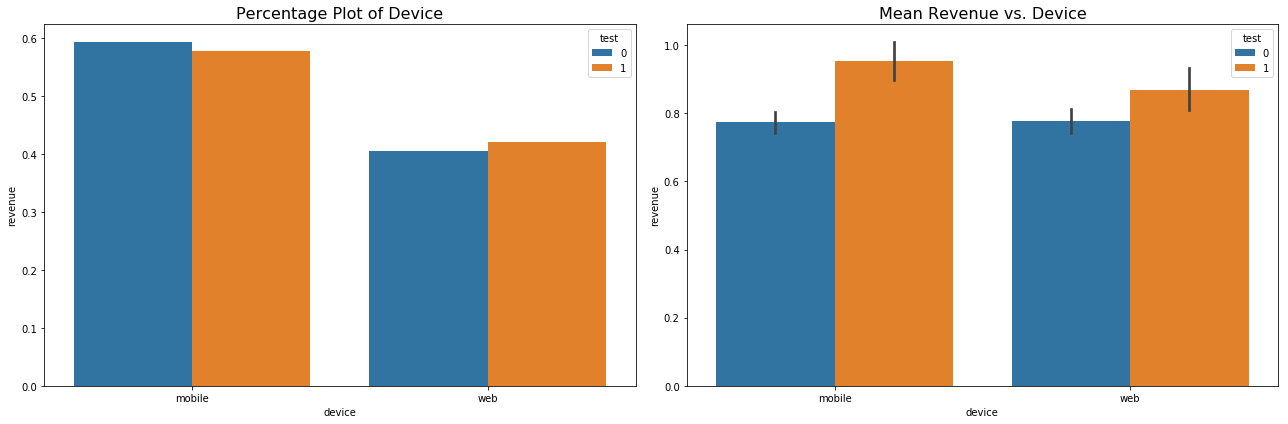

In [23]:
# Visualization of device
count = data[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

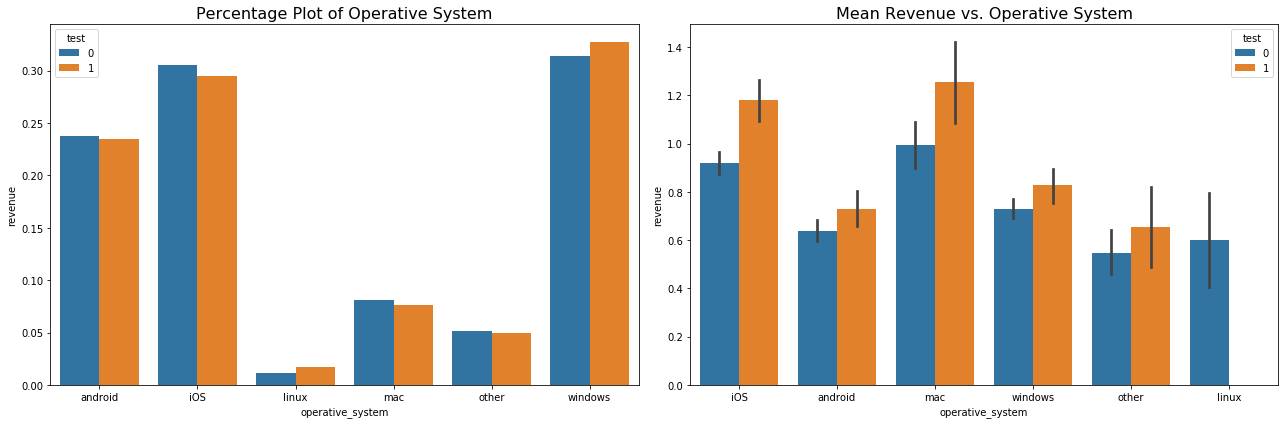

In [24]:
# Visualization of operative system
count = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='operative_system', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Operative System', fontsize=16)
plt.tight_layout()
plt.show()

# Analysis

In [25]:
# check the conversion rate for A/B test
data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [26]:
# check the revenue
data[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


Clearly, for those with lower price $\$39$, they have a higher conversion rate $1.990\%$. For those with higher price $\$59$, the conversion rate is $1.556\%$. However, considering the price, the average revenue for higher price ($0.918$) is actually larger than the lower price ($0.776$).